In [1]:
# Cell 1 : Librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")  # style graphique
pd.set_option('display.max_columns', None)

In [3]:
# Cell 2 : Charger les données GOLD
gold_path = "/home/mountah_lodia/ecommerce_project/ecommerce_project/data/gold/ecommerce_features.parquet"
df = pd.read_parquet(gold_path)
df.head()

,CustomerID,recency_days,frequency,monetary,total_items,avg_price,total_returns
0,17420,50,30,598.83,265,3.881333,0.0
1,16503,106,84,1431.93,569,4.173571,0.0
2,15727,16,302,5178.96,3065,3.248146,0.0
3,17389,0,213,31833.68,7612,5.688826,0.0
4,15447,330,9,155.17,85,3.121111,0.0


In [4]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     4338 non-null   int32  
 1   recency_days   4338 non-null   int32  
 2   frequency      4338 non-null   int64  
 3   monetary       4338 non-null   float64
 4   total_items    4338 non-null   int64  
 5   avg_price      4338 non-null   float64
 6   total_returns  4338 non-null   float64
dtypes: float64(3), int32(2), int64(2)
memory usage: 203.5 KB


In [5]:
# ----------------------------
# Cell 4 : RFM Segmentation
# ----------------------------

# Récence, Fréquence, Montant
df_rfm = df.copy()
df_rfm['recency_days'] = df_rfm['recency_days']
df_rfm['frequency'] = df_rfm['frequency']
df_rfm['monetary'] = df_rfm['monetary']

# Segmenter avec des scores 1-5 (quintiles)
df_rfm['R_score'] = pd.qcut(df_rfm['recency_days'], 5, labels=[5,4,3,2,1])
df_rfm['F_score'] = pd.qcut(df_rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
df_rfm['M_score'] = pd.qcut(df_rfm['monetary'], 5, labels=[1,2,3,4,5])

# Score RFM
df_rfm['RFM_score'] = df_rfm['R_score'].astype(str) + df_rfm['F_score'].astype(str) + df_rfm['M_score'].astype(str)

df_rfm.head(10)



,CustomerID,recency_days,frequency,monetary,total_items,avg_price,total_returns,R_score,F_score,M_score,RFM_score
0,17420,50,30,598.83,265,3.881333,0.0,3,3,3,333
1,16503,106,84,1431.93,569,4.173571,0.0,2,4,4,244
2,15727,16,302,5178.96,3065,3.248146,0.0,4,5,5,455
3,17389,0,213,31833.68,7612,5.688826,0.0,5,5,5,555
4,15447,330,9,155.17,85,3.121111,0.0,1,1,1,111
5,14450,180,40,483.25,241,2.790500,0.0,1,3,2,132
6,15100,333,3,876.00,80,10.950000,0.0,1,1,3,113
7,16916,23,143,576.26,440,2.220420,0.0,4,5,3,453
8,12471,2,460,19824.05,8212,4.300370,0.0,5,5,5,555
9,14514,61,73,1055.35,589,3.226438,0.0,3,4,4,344


# commentaires 
Le score RFM est une combinaison des scores de récence, fréquence et montant.
Un score élevé indique un client précieux (achat récent, fréquent et montant élevé).
Un score faible indique un client moins engagé.

In [6]:
# ----------------------------
# Cell 5 : Définir segments
# ----------------------------
def rfm_segment(df):
    if df['R_score']==5 and df['F_score']==5 and df['M_score']==5:
        return 'Champions'
    elif df['R_score']>=4 and df['F_score']>=4:
        return 'Loyal'
    elif df['R_score']>=3:
        return 'Potential'
    elif df['R_score']<=2 and df['F_score']<=2:
        return 'At Risk'
    else:
        return 'Others'

df_rfm['Segment'] = df_rfm.apply(rfm_segment, axis=1)
df_rfm['Segment'].value_counts()




Segment
Potential    1521
At Risk      1067
Loyal         784
Others        660
Champions     306
Name: count, dtype: int64

# commentaires 
Les "Champions" sont les clients les plus précieux, achetant fréquemment et récemment.
Les clients "Loyal" achètent souvent et récemment, mais pas autant que les Champions.
Les clients "Potential" ont acheté récemment mais pas fréquemment.    
Les clients "At Risk" n'ont pas acheté récemment et achètent rarement.
"Others" regroupe les clients ne correspondant pas aux autres segments.

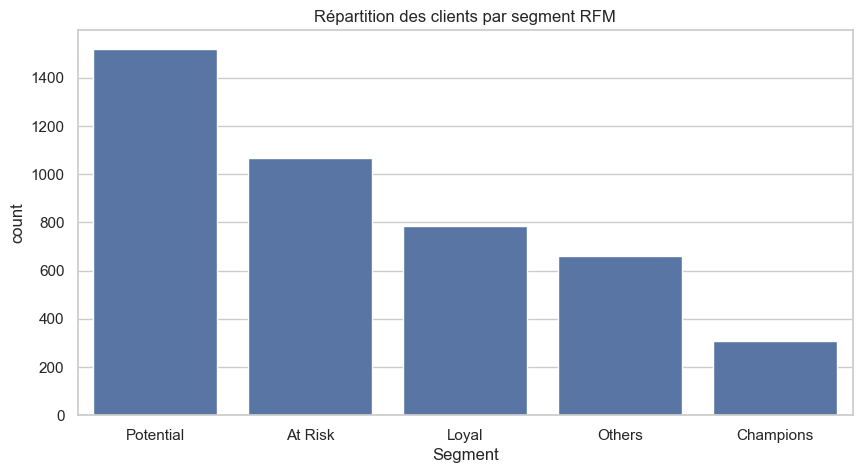

In [7]:
# ----------------------------
# Cell 6 : Visualisation
# ----------------------------
plt.figure(figsize=(10,5))
sns.countplot(x='Segment', data=df_rfm, order=df_rfm['Segment'].value_counts().index)
plt.title("Répartition des clients par segment RFM")
plt.show()

# commentaires
# Les "Champions" représentent les clients les plus précieux, tandis que les segments "At Risk" nécessitent une attention particulière pour éviter la perte de clients.
# Cela permet de cibler les stratégies marketing en fonction du comportement des clients.


# Observations

Dominant : 
Le segment Potential est le plus grand (barre la plus haute).

Peu de Champions : 
Le segment Champions est le plus petit (moins d’un quart des plus gros segments).
Distribution déséquilibrée :

La majorité des clients est dans des segments à potentiel moyen/risqué plutôt que dans les clients très fidèles/hauts contributeurs.

Implication RFM : 
Beaucoup de clients ont probablement acheté récemment (R élevé) mais pas assez fréquemment ou avec montant élevé pour devenir Champions.

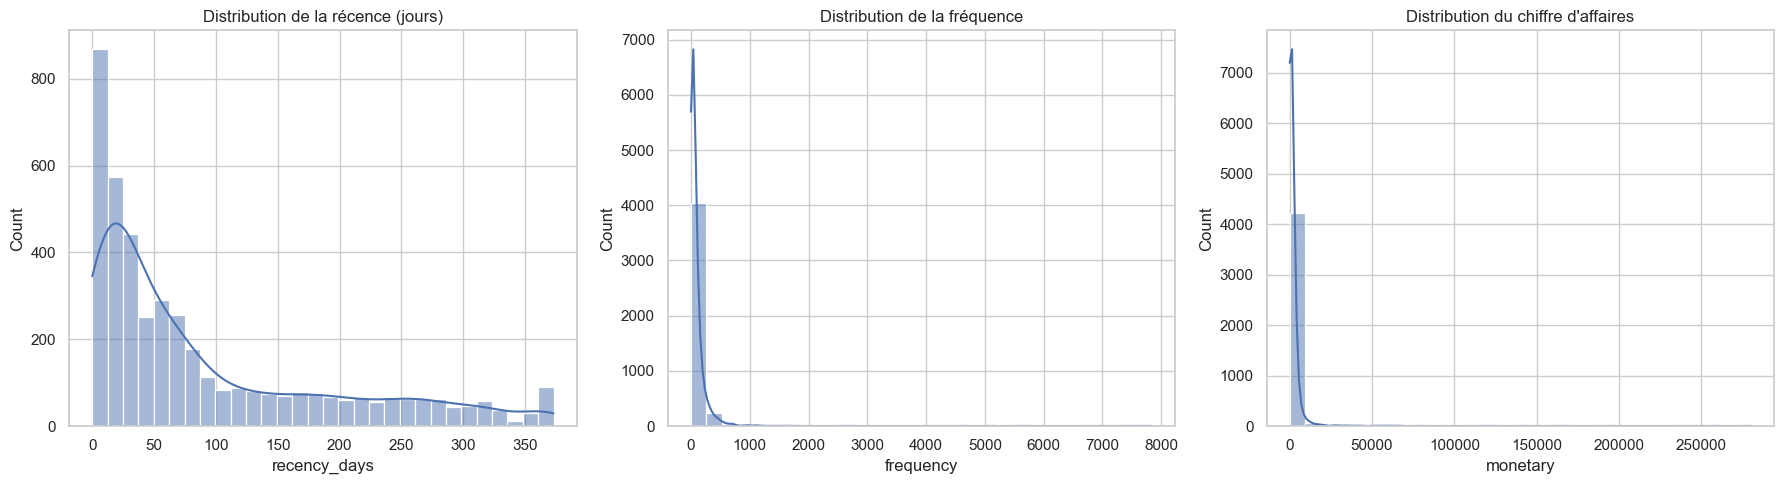

In [8]:
# Distribution Recency, Frequency, Monetary
fig, axs = plt.subplots(1,3, figsize=(18,5))

sns.histplot(df_rfm['recency_days'], bins=30, kde=True, ax=axs[0])
axs[0].set_title("Distribution de la récence (jours)")

sns.histplot(df_rfm['frequency'], bins=30, kde=True, ax=axs[1])
axs[1].set_title("Distribution de la fréquence")

sns.histplot(df_rfm['monetary'], bins=30, kde=True, ax=axs[2])
axs[2].set_title("Distribution du chiffre d'affaires")

plt.tight_layout()
plt.show()



# Observations (visuelles & statistiques)

 Récence: 
Distribution fortement asymétrique à droite (long tail). Beaucoup de clients ont une faible récence (achat récent) ; une queue importante jusqu'à ~365 jours.

 Fréquence: 
Très fortement skewée à droite — la majorité des clients ont faible fréquence d'achat, quelques clients très fréquents tirent la queue.

 Montant (CA): 
Extrême asymétrie — la plupart des clients génèrent de petits montants et une petite portion génère un CA très élevé (outliers).


C:\Users\mount\AppData\Local\Temp\ipykernel_33548\625343970.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rfm_pivot = df_rfm.pivot_table(index='R_score', columns='F_score', values='monetary', aggfunc='mean')


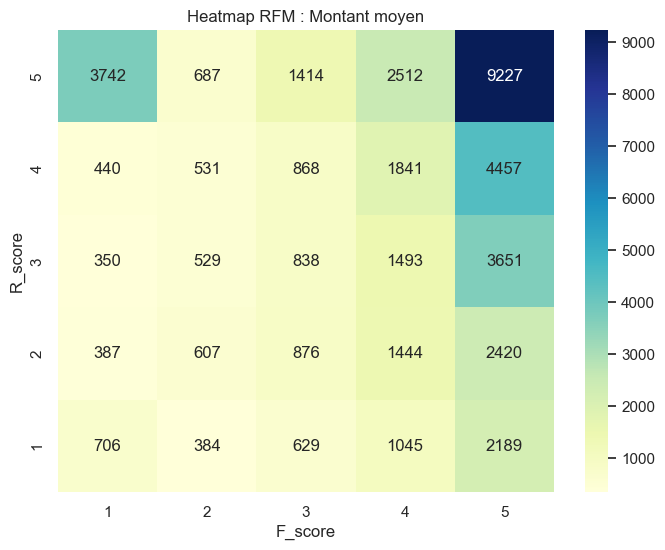

In [10]:
# ----------------------------
# Cell 7 : Heatmap RFM
# ----------------------------
rfm_pivot = df_rfm.pivot_table(index='R_score', columns='F_score', values='monetary', aggfunc='mean')
plt.figure(figsize=(8,6))
sns.heatmap(rfm_pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title("Heatmap RFM : Montant moyen")
plt.show()

# Gradient clair: 
la valeur moyenne du monetary augmente quand R_score (récence plus élevée = achats plus récents) et F_score (fréquence) augmentent. Le coin haut-droite (R=5, F=5) affiche la plus forte moyenne (~9 227), indiquant que les clients les plus récents ET les plus fréquents génèrent nettement plus de CA.
# Effet combiné: 
l’augmentation est plutôt monotone le long des deux axes — preuve que récence+fréquence corrèlent positivement avec valeur monétaire.
# Influence des outliers: 
les valeurs (moyennes) très élevées dans certaines cellules suggèrent que quelques clients très gros tirent la moyenne vers le haut.